In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.misc
import os

from ImageUtils import *
from imageio import imread
from scipy.io import loadmat
from scipy.stats import entropy
from scipy.special import kolmogorov
from scipy import ndimage
import seaborn as sns

In [181]:
npand = np.logical_and
### Load behavioral data
bd = loadmat('/Users/akshay/proj/TextureSynthesis/behav_data/s352.mat')

# Process behavioral data
fix_str_vec = lambda vec: np.array([str(vec[0][i][0]) for i in range(len(vec[0]))], dtype='string_')
bd['imNames'] = fix_str_vec(bd['imNames'])
bd['rfNames'] = fix_str_vec(bd['rfNames'])
bd['layerNames'] = fix_str_vec(bd['layerNames'])
bd['rf_sz_deg'] = 6.0 / bd['rf_size']
bd['nLayers'] = len(np.unique(bd['layer']))
bd['nRfSizes'] = len(np.unique(bd['rf_size']))

In [183]:
def compute_gram_corrs(gram_mtx):
    nSubsets = gram_mtx['pool1'].shape[2]
    layers = ['pool1', 'pool2', 'pool4']
    corrs = []
    for li in layers:
        #print li
        gm = gram_mtx[li]
        sub_comb = np.array(np.meshgrid(range(nSubsets), range(nSubsets))).T.reshape(-1,2)
        cs = []
        for si in range(sub_comb.shape[0]):
            s1,s2 = sub_comb[si]
            if s1 != s2:
                sub1 = gm[:,:,s1]
                sub2 = gm[:,:,s2]
                subcorr = np.corrcoef(sub1.flatten(), sub2.flatten())[0,1].astype(float)
                cs.append(subcorr)
        corrs.append(np.mean(cs))

    return corrs

def compute_RF_slopes(imIdx, bd=bd):
    ct = bd['corr_trials']
    slopes = []
    for li in range(bd['nLayers']):        
        acc = np.zeros(bd['nRfSizes'])
        xs = np.zeros(bd['nRfSizes'])
        for rfI in range(bd['nRfSizes']):
            # Compute accuracy at a particular layer, 
            acc[rfI] = np.nanmean(ct[npand(npand(bd['image']==imIdx+1, bd['layer']==li+1), bd['rf_size']==rfI+1)])
            xs[rfI] = 6.0 / (rfI+1)
        
        # fit slope
        slopes.append(np.polyfit(xs, acc, 1)[0])
        
    return slopes

def compute_mean_acc(imIdx, bd=bd):
    ct = bd['corr_trials']
    accs = np.zeros((bd['nLayers'], bd['nRfSizes']))
    for li in range(bd['nLayers']):        
        acc = np.zeros(bd['nRfSizes'])
        for rfI in range(bd['nRfSizes']):
            # Compute accuracy at a particular layer, 
            accs[li,rfI] = np.nanmean(ct[npand(npand(bd['image']==imIdx+1, bd['layer']==li+1), bd['rf_size']==rfI+1)])

    return accs

In [173]:
# Get all the correlations and slopes into a big matrix
im_corrs = np.zeros((len(imNames), bd['nLayers']))
im_slopes = np.zeros((len(imNames), bd['nLayers']))
im_accs = np.zeros((len(imNames), bd['nLayers'], bd['nRfSizes']))
for imI in range(len(imNames)):
    im = imNames[imI]
    
    gram_mtx = np.load('tmp/gram_%s.npy' % (im)).item()
    
    im_corrs[imI,:] = compute_gram_corrs(gram_mtx)
    im_slopes[imI,:] = compute_RF_slopes(imI,bd)
    im_accs[imI,:,:] = compute_mean_acc(imI,bd)

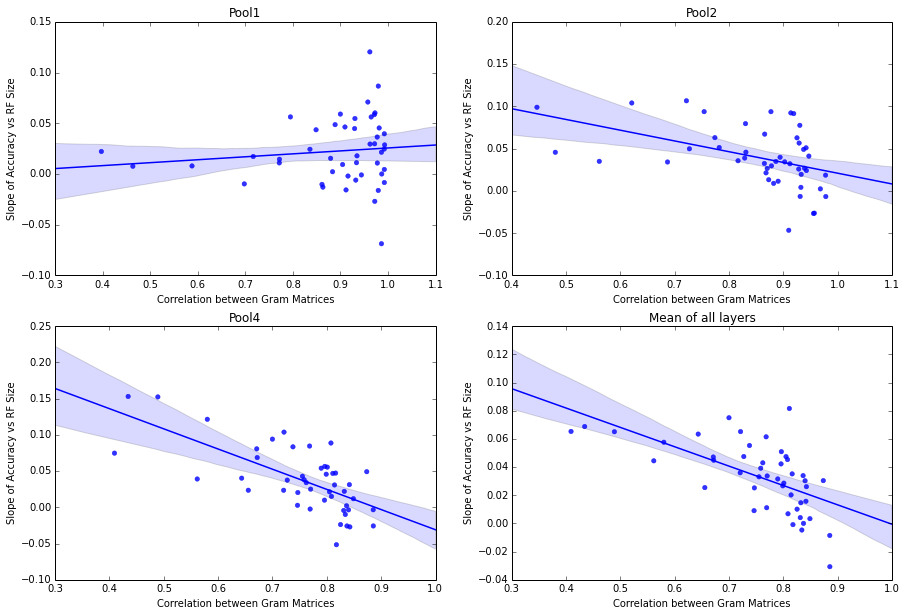

In [169]:
### Plot Gram Matrix Correlation VS RFSize Slopes
fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(221)
sns.regplot(x=im_corrs[:,0], y = im_slopes[:,0])
plt.xlabel('Correlation between Gram Matrices')
plt.ylabel('Slope of Accuracy vs RF Size')
plt.title('Pool1')

ax = fig.add_subplot(222)
sns.regplot(x=np.mean(im_corrs[:,0:2], axis=1), y = im_slopes[:,1])
plt.xlabel('Correlation between Gram Matrices')
plt.ylabel('Slope of Accuracy vs RF Size')
plt.title('Pool2')

ax = fig.add_subplot(223)
sns.regplot(x=np.mean(im_corrs[:,:], axis=1), y = im_slopes[:,2])
plt.xlabel('Correlation between Gram Matrices')
plt.ylabel('Slope of Accuracy vs RF Size')
plt.title('Pool4')

ax = fig.add_subplot(224)
sns.regplot(x=np.mean(im_corrs,axis=1), y=np.mean(im_slopes,axis=1))
plt.xlabel('Correlation between Gram Matrices')
plt.ylabel('Slope of Accuracy vs RF Size')
plt.title('Mean of all layers')

In [187]:
### 
print bd.keys()
bd['layer'].shape
bd

['reaction_time', 'image', 'rf_size', 'imSz', 'run', 'subj_resp', 'corr_resp', 'nRfSizes', 'corr_trials', 'layer', '__version__', 'nLayers', 'ecc', 'accByRuns', 'layerNames', 'nRuns', 'rf_sz_deg', 'rfNames', '__header__', '__globals__', 'nValTrials', 'nTrials', 'imNames']


{'__globals__': [],
 '__header__': 'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Fri Jun 29 16:37:30 2018',
 '__version__': '1.0',
 'accByRuns': array([[ 0.66666667,  0.65277778,  0.63888889,  0.72916667,  0.75694444,
          0.72916667,  0.77083333,  0.52083333,  0.4375    ,  0.60416667,
          0.64583333,  0.69444444,  0.63888889,  0.61805556,  0.625     ,
          0.71527778,  0.65972222,  0.64583333,  0.63194444,  0.68055556,
          0.58333333,  0.57638889,  0.63194444,  0.64583333,  0.65972222,
          0.68055556,  0.65277778,  0.63888889,  0.67361111,  0.59027778,
          0.67361111,  0.65277778,  0.63194444,  0.59027778,  0.61111111,
          0.6875    ,  0.66666667,  0.75      ,  0.71527778,  0.6875    ,
          0.73611111,  0.73611111,  0.72916667,  0.75694444,  0.64583333,
          0.72916667,  0.64583333,  0.63194444,  0.60416667,  0.69444444,
          0.71527778,  0.67361111,  0.66666667,  0.71527778,  0.72916667,
          0.78472222,  0.77083333,  